In [2]:
from influxdb import InfluxDBClient, DataFrameClient
fconfig = dict(x.split()  for x in open("fconfig.txt").readlines())
dclient = DataFrameClient(fconfig["host"], 8086, fconfig["username"], fconfig["password"], fconfig["database"])


In [311]:
hoursback(10)


('2022-05-01 23:09:09', '2022-05-02 09:09:09')

In [4]:
from matplotlib import pyplot as plt
import datetime

def hoursback(h0, h1=0):
    t0 = (datetime.datetime.utcnow() - datetime.timedelta(hours=h0)).isoformat(" ", "seconds")
    t1 = (datetime.datetime.utcnow() - datetime.timedelta(hours=h1)).isoformat(" ", "seconds")
    return t0, t1

# read the two sensors between a period of times and find the line of regression to calibrate them
t0, t1 = '2022-04-29 22:00:00', '2022-04-30 15:00:00'
t0, t1 = '2022-05-01 10:00:00', '2022-05-01 17:00:00'
t0, t1 = '2022-05-01 21:00:00', '2022-05-02 17:00:00'
#t0, t1 = hoursback(12)

devices = ['7AEDB8', 'AB4634', '7872E8']
timerange = "time>'%s' and time<'%s'" % (t0, t1)
groupby = "group by time(5m)"
dfs = [ ]
for device in devices:
    print(device)
    query = "select mean(co2) as co2_%s from julianhouse where device='%s' and %s %s" % \
                (device, device, timerange, groupby)
    print(query)
    s = dclient.query(query)
    dfs.append(s["julianhouse"].dropna())
co2minutes = pandas.concat(dfs, axis=1)

fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
for dev in devices:
    plt.plot(co2minutes["co2_%s"%dev], label=dev)
plt.legend()

ax = plt.subplot(1,3,2)
dev0 = devices[0]
dat0 = co2minutes["co2_%s"%dev0]
dat1moved = [ ]
print("add the calculations below into the grafana math node")
for dev1 in devices[1:]:
    dat1 = co2minutes["co2_%s"%dev1]
    plt.plot(dat0, dat1)
    model1 = numpy.polyfit(dat1, dat0, 1)
    print(dev1, 'mean("co2")*%f + %f' % tuple(model1))
    dat1moved.append(dat1*model1[0] + model1[1])
    
ax = plt.subplot(1,3,3)
plt.plot(dat0)
for dat1m in dat1moved:
    plt.plot(dat1m)


7AEDB8
select mean(co2) as co2_7AEDB8 from julianhouse where device='7AEDB8' and time>'2022-05-01 21:00:00' and time<'2022-05-02 17:00:00' group by time(5m)


KeyboardInterrupt: 

In [165]:
# readings approx 0.000770 when one person asleep in house, then 0.000400 when doors open
# CO2 production of a sleeping person is 0.25 l/m
# if E is the exchange volume per minute, this differential is stable if E*(0.000770 - 0.000400) = 0.25
# E = 0.25/0.00037 = 675 l/m
# If the volume of the house is 120 m3 then it's an air exchange of 120/0.675 or once every 3hrs

# My calculation is: Air exchange = Human production of CO2/(inside_CO2_concentration - outside_CO2_concentration)
#                                 = 0.25/(0.000770 - 0.000400) = 675 litres/minute
# Air exchanges per hour = Air exchange/House volume = 675*60/120000 = 0.33 exchanges per hour


0.3375

(0.015661117030946754, 388.20725005952175, 540.2508613438699)


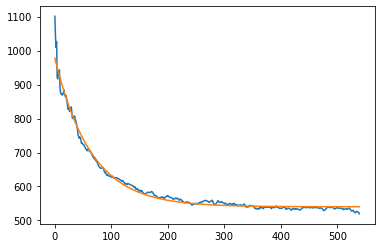

In [218]:
# Events room calculation.  Room volume 190 m3

t0, t1 = '2022-04-29 21:00:00', '2022-04-30 06:00:00'
device = '7AEDB8'
timerange = "time>'%s' and time<'%s'" % (t0, t1)
groupby = "group by time(1m)"
query = "select mean(co2) as co2_%s from julianhouse where device='%s' and %s %s" % (device, device, timerange, groupby)
s = dclient.query(query)
co2minutes = s["julianhouse"]

t0 = co2minutes.index[0] 
minute = (co2minutes.index - t0)/pandas.Timedelta(seconds=60)

import scipy.optimize
def fun(X):
    d = numpy.exp((X[1]-minute)*X[0]) + X[2] - co2minutes.co2_7AEDB8
    return sum(d**2)
#plt.plot(minute, co2minutes)
#plt.plot(minute, numpy.exp((300-minute)*0.02) + 540)
sol = scipy.optimize.minimize(fun, (0.02, 300.0, 540.0), method="Powell")
print(tuple(sol.x))

plt.plot(minute, co2minutes.co2_7AEDB8)
X = (0.015661117030946754, 388.20725005952175, 540.2508613438699)
plt.plot(minute, numpy.exp((X[1]-minute)*X[0]) + X[2])


In [8]:
0.015*60

0.8999999999999999

In [223]:
# Rate of exchange is 0.015*190*1000 = 2850 l/m
# It had been around a concentration of 0.0012
# This means the production of CO2/minute was 2850*(0.0012-0.000540)=1.88 l/m CO2
# or a production of around 0.313 l/m per person (there were 6 people)


0.31349999999999995

In [215]:
import scipy.optimize
def fun(X):
    d = numpy.exp((X[1]-minute)*X[0]) + X[2] - co2minutes.co2_7AEDB8
    return sum(d**2)
#plt.plot(minute, co2minutes)
#plt.plot(minute, numpy.exp((300-minute)*0.02) + 540)
sol = scipy.optimize.minimize(fun, (0.02, 300.0, 540.0), method="Powell")
print(tuple(sol.x))

(0.015661117030946754, 388.20725005952175, 540.2508613438699)


[0.0156565828, 436.942807, 540.222792]

(0.015661117030946754, 388.20725005952175, 540.2508613438699)


380.65862957756644

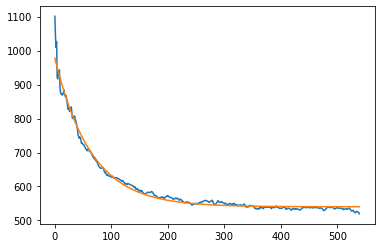

In [216]:
import scipy.optimize
plt.plot(minute, co2minutes.co2_7AEDB8)
X = (0.015661117030946754, 388.20725005952175, 540.2508613438699)
plt.plot(minute, numpy.exp((X[1]-minute)*X[0]) + X[2])


In [256]:
# this turns out to be the Savitzky-Golay filter
sec1 = pandas.Timedelta(seconds=1)
def intercurvefitdifferentiate(seriestimeindex, rx, ws, deg=3):
    rx0 = pandas.Series(0, seriestimeindex)
    rx1 = pandas.Series(0, seriestimeindex)
    rx2 = pandas.Series(0, seriestimeindex)
    wt = ws*sec1
    wt2 = ws*2*sec1
    wt4 = ws*4*sec1
    for n in range(len(seriestimeindex)):
        t = seriestimeindex[n]
        lx = rx[t-wt:t+wt]
        if len(lx) <= 3:
            lx = rx[t-wt2:t+wt2]
            if len(lx) <= 3:
                lx = rx[t-wt4:t+wt4]
                if len(lx) <= 3:
                    #print(t)
                    continue
        ts = (lx.index - t)/sec1
        weights = 1/((abs(ts)/ws)**2+1)
        pm = numpy.polyfit(ts, lx, deg=deg, w=weights)
        rx0.iloc[n] = numpy.polyval(pm, 0)
        pm1 = numpy.polyder(pm)
        rx1.iloc[n] = numpy.polyval(pm1, 0)
        pm2 = numpy.polyder(pm, 2)
        rx2.iloc[n] = numpy.polyval(pm2, 0)
    return rx0, rx1, rx2


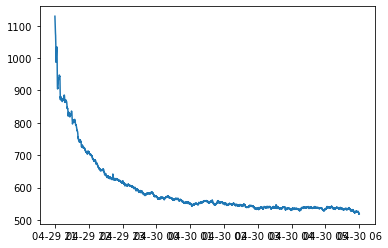

In [258]:
t0, t1 = '2022-04-29 21:00:00', '2022-04-30 06:00:00'
device = '7AEDB8'
timerange = "time>'%s' and time<'%s'" % (t0, t1)
query = "select co2 as co2_%s from julianhouse where device='%s' and %s" % (device, device, timerange)
s = dclient.query(query)
rx = s["julianhouse"]["co2_7AEDB8"]

plt.plot(rx)

In [287]:
seriestimeindex = pandas.date_range(rx.index[0], rx.index[-1], freq="180s")
rx0, rx1, rx2 = intercurvefitdifferentiate(seriestimeindex, rx, 6000, deg=3)

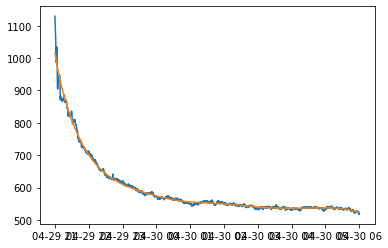

In [288]:
plt.plot(rx)
plt.plot(rx0)


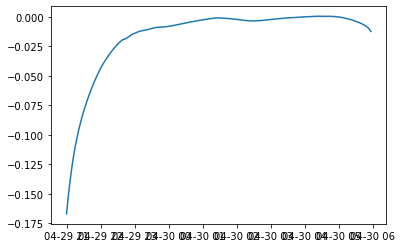

In [291]:
plt.plot(rx1)

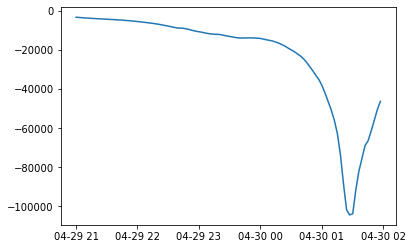

In [298]:
y = (rx0-460)/rx1
plt.plot(y[:100])

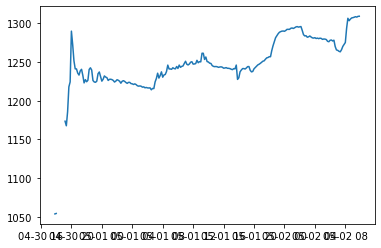

In [339]:
t0 = (datetime.datetime.utcnow() - datetime.timedelta(hours=40))
t0u = t0.isoformat(sep=" ", timespec="seconds")
s = dclient.query("select pow(10, (8.1332 - 1762.39/(mean(temp)+235.66)))*133.322387415*mean(humid)/100 as wv from julianhouse where device='7AEDB8' and time>'%s' group by time(10m);" % t0u)
#wv = 10**(8.1332 - 1762.39/(df["temp"] + 235.66))*133.322387415*df["humid"]/100
plt.plot(s["julianhouse"])


In [322]:
t0 = (datetime.datetime.utcnow() - datetime.timedelta(seconds=1000))
t0u = t0.isoformat(sep=" ", timespec="seconds")
print(t0, t0u)
#s = dclient.query("select co2, humid, temp from julianhouse where device='7AEDB8' and time>'%s';" % t0u)
s = dclient.query("select mean(co2), mean(humid), mean(temp) from julianhouse where device='7AEDB8' and time>'%s' group by time(10m);" % t0u)

#s = dclient.query("select co2 from julianhouse where time>'2022-04-30 16:00:05' limit 10;")
df = s["julianhouse"]
svp = 10**(8.1332 - 1762.39/(df["temp"] + 235.66))*133.322387415
watervapour = svp*df["humid"]/100

wv = 10**(8.1332 - 1762.39/(df["temp"] + 235.66))*133.322387415*df["humid"]/100

plt.plot(wv)
def SaturationVapourPressure(tempseries):
    A, B, C = 8.1332, 1762.39, 235.66
    return 10**(A - B/(tempseries + C))*133.322387415
    
def DewpointTemperature(tempseries, humidseries):
    A, B, C = 8.1332, 1762.39, 235.66
    svp = 10**(A - B/(tempseries + C))*133.322387415
    pvp = svp*humidseries/100
    return -C - B/(numpy.log10(pvp/133.322387415) - A)

# http://en.wikipedia.org/wiki/Density_of_air
def AirDensity(tempseries, humidityseries, pressureseries):
    saturationvapourpressure = SaturationVapourPressure(tempseries)
    PPwatervapour = SaturationVapourPressure(tempseries)*humidityseries/100
    PPdryair = pressureseries - PPwatervapour
    Rdryair = 287.058
    Rwatervapour = 461.495
    tempK = tempseries + 273.15
    return PPdryair/(Rdryair*tempK) + PPwatervapour/(Rwatervapour*tempK)
df


2022-05-02 09:36:22.399547 2022-05-02 09:36:22


KeyError: 'temp'